In [2]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import scipy.stats as st
import math
from scipy import signal

Read antpos from etcd


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [2]:
%load_ext line_profiler

In [3]:
counterfile='/home/ubuntu/kp/data/newpacketizer/cosmic_ray_system_2023-03-23_1205/counter1679614319.2388244.dat'
constantsfile='/home/ubuntu/kp/data/newpacketizer/cosmic_ray_system_2023-03-23_1205/constant1679614293.2181191.dat'

In [4]:
counter_records=parsefile(counterfile)
constants_records=parsefile(counterfile)
print(len(counter_records))
print(len(constants_records))

64
64


I want to try to make a faster unpackdata function and compare its performance to the old version. The unpackdata function is called within parsefile. Below, the function parsefile_test is a copy of parsefile from cr_data_inspection_functions.py except that it calls unpackdata_test instead of unpack_data. Similarly, unpackdata_old and parsefile_old are copies of the original. The function test_unpackdata is what I'll be changing.  With this way of organizing the code, I can profile the old and new versions for comparison by doing %lprun -f unpackdata parsefile(counterfile) and %lprun -f unpackdata_test parsefile_test(counterfile)

In [3]:


def parsefile_test(fname, start_ind=None, end_ind=None):
    #get data and header from a file (fname) with raw data from an arbitrary number of cosmic ray packets
    #returns a list of dictionaries, with one dictionary per packet
    #the data key contains a numpy array of the timeseries and the other keys are header info as specified by the parseheader function
    packet_size = 8192
    if os.path.getsize(fname)%packet_size: 
        print("File contains incomplete packets")
        return
    records = []
    i = 0
    if start_ind == None or start_ind < 0:
        start_ind = 0
    byte_start = start_ind * packet_size
    with open(fname, mode="rb") as datafile:   #read the file
        datafile.seek(byte_start)
        for piece in read_in_chunks(datafile, packet_size):
            data_dict = parseheader(piece)
            data_dict['data'] = unpackdata_test(piece, '>h')[16:-32]
            records.append(data_dict)
            i+=1
            if i == end_ind:
                break
    return records

def unpackdata_test(rawpacketdata,datatype):
    #parse raw bytes into a numpy array
    #pairs of bytes are interpreted as 16 bit integers, and the last 32 bytes are omitted as they are the header
    #raw packet data is the data payload of a UDP packet from the cosmic ray firmware, including the header word
    #datatype can be signed or unsigned and big endian or little endian, but must be a 16-bit data type. This argument was only for debugging
    unpackeddata=np.frombuffer(rawpacketdata[:-32],dtype=datatype)
    return unpackeddata

def parsefile_old(fname, start_ind=None, end_ind=None):
    #get data and header from a file (fname) with raw data from an arbitrary number of cosmic ray packets
    #returns a list of dictionaries, with one dictionary per packet
    #the data key contains a numpy array of the timeseries and the other keys are header info as specified by the parseheader function
    packet_size = 8192
    if os.path.getsize(fname)%packet_size: 
        print("File contains incomplete packets")
        return
    records = []
    i = 0
    if start_ind == None or start_ind < 0:
        start_ind = 0
    byte_start = start_ind * packet_size
    with open(fname, mode="rb") as datafile:   #read the file
        datafile.seek(byte_start)
        for piece in read_in_chunks(datafile, packet_size):
            data_dict = parseheader(piece)
            data_dict['data'] =unpackdata_old(piece, '>h')[16:-32]

            records.append(data_dict)
            i+=1
            if i == end_ind:
                break
    return records

def unpackdata_old(rawpacketdata,datatype):
    #parse raw bytes into a numpy array
    #pairs of bytes are interpreted as 16 bit integers, and the last 32 bytes are omitted as they are the header
    #raw packet data is the data payload of a UDP packet from the cosmic ray firmware, including the header word
    #datatype can be signed or unsigned and big endian or little endian, but must be a 16-bit data type. This argument was only for debugging
    nbytes=len(rawpacketdata)
    unpackeddata=np.zeros(int((nbytes-32)/2),dtype=datatype)
    for i in range(int((nbytes-32)/2)):
        value=struct.unpack(datatype,rawpacketdata[(2*i):(2*i +2)]) #read a pair of bytes as an integer. Last 32 bytes are header
        unpackeddata[i]=value[0] 
    return unpackeddata

In [12]:
%lprun -f unpackdata_test parsefile_test(counterfile)

In [13]:
%lprun -f unpackdata_old parsefile_old(counterfile)

In [19]:
%lprun -f parsefile_old parsefile_old(counterfile)

In [20]:
%lprun -f parsefile parsefile(counterfile)

# Test that the behavior is the same

0 0
0 0


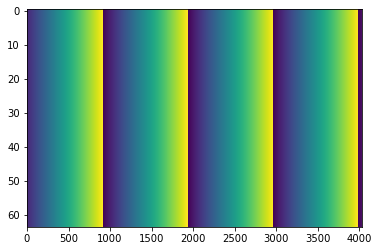

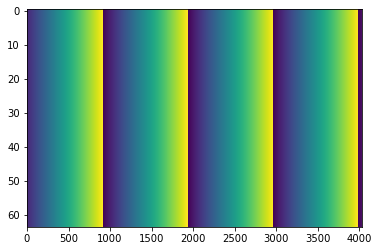

In [6]:
old=parsefile_old(counterfile)
new=parsefile_test(counterfile)
current=parsefile(counterfile)

timeseries_old=np.asarray([record['data'] for record in old])
timeseries_new=np.asarray([record['data'] for record in new])
timeseries_current=np.asarray([record['data'] for record in current])
difference=timeseries_old-timeseries_new
check=timeseries_new-timeseries_current

plt.figure()
plt.imshow(timeseries_old,aspect='auto',interpolation='none')

plt.figure()
plt.imshow(timeseries_new,aspect='auto',interpolation='none')

print(difference.min(),difference.max())
print(check.min(),check.max())


0 0
0 0


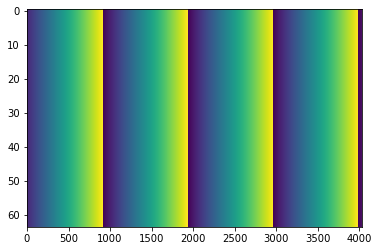

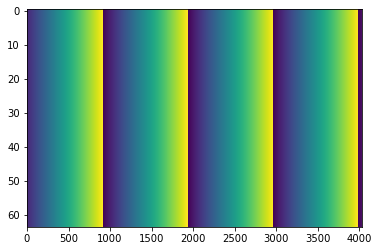

In [7]:
timeseries_old=np.asarray([record['data'] for record in old])
timeseries_new=np.asarray([record['data'] for record in new])
timeseries_current=np.asarray([record['data'] for record in current])
difference=timeseries_old-timeseries_new
check=timeseries_new-timeseries_current

plt.figure()
plt.imshow(timeseries_old,aspect='auto',interpolation='none')

plt.figure()
plt.imshow(timeseries_new,aspect='auto',interpolation='none')

print(difference.min(),difference.max())
print(check.min(),check.max())



# Test with real data on gpu9 to make sure nothing got messed up in the git merge

0 0


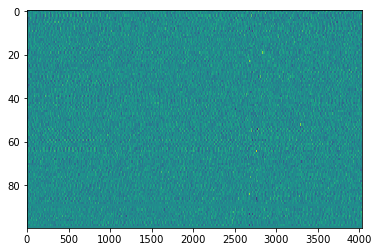

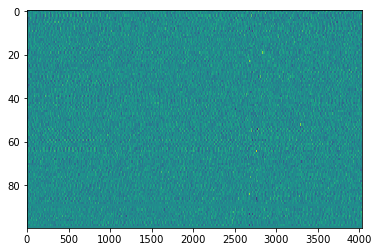

In [5]:
datafile='/data0/cosmic-ray-data/2023August9/overnight1691665695.421232.dat'
old=parsefile_old(datafile,end_ind=100)
current=parsefile(datafile,end_ind=100)

timeseries_old=np.asarray([record['data'] for record in old])
timeseries_current=np.asarray([record['data'] for record in current])
check=timeseries_old-timeseries_current

plt.figure()
plt.imshow(timeseries_old,aspect='auto',interpolation='none')

plt.figure()
plt.imshow(timeseries_current,aspect='auto',interpolation='none')

print(check.min(),check.max())

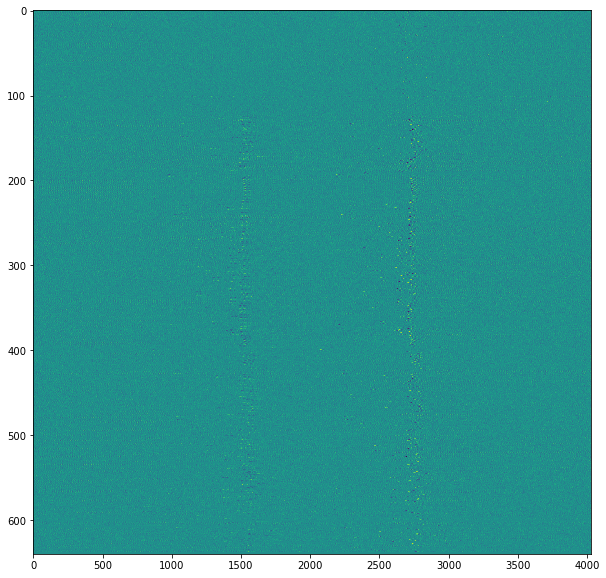

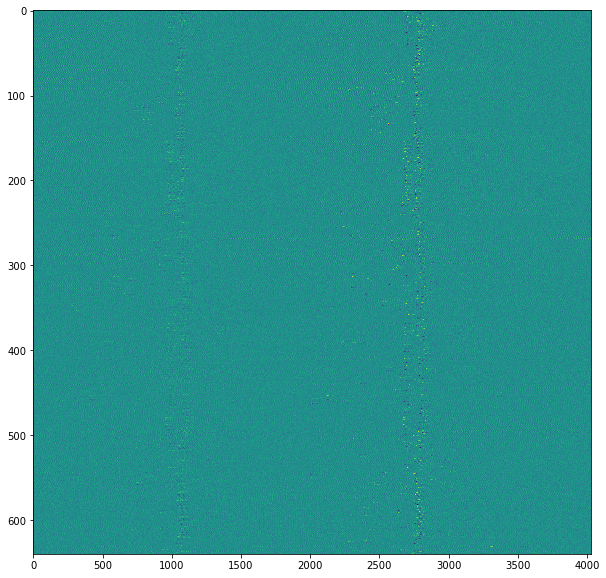

In [8]:
datafile='/data0/cosmic-ray-data/2023August9/overnight1691665695.421232.dat'
current=parsefile(datafile,end_ind=640)

timeseries_current=np.asarray([record['data'] for record in current])

plt.figure(figsize=(10,10))
plt.imshow(timeseries_current,aspect='auto',interpolation='none')

current=parsefile(datafile,start_ind=10000,end_ind=640)

timeseries_current=np.asarray([record['data'] for record in current])

plt.figure(figsize=(10,10))
plt.imshow(timeseries_current,aspect='auto',interpolation='none')




# Scratchwork learning how to use np.frombuffer()

In [37]:
testbytes=b'\x01\x02\x03\x04\x05'

a=np.frombuffer(testbytes, dtype=np.uint8, count=3)
b=np.frombuffer(testbytes, dtype=np.uint8)
c=np.frombuffer(testbytes, dtype=np.uint16,count=2)
d=np.frombuffer(testbytes, dtype='>h',count=2)
e=np.frombuffer(testbytes[:-1], dtype='>h')

In [35]:
print(testbytes[:-1])

b'\x01\x02\x03\x04'


In [38]:
print(a)
print(b)
print(c)
print(d)
print(e)

[1 2 3]
[1 2 3 4 5]
[ 513 1027]
[258 772]
[258 772]
